In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = True
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

import numpy as np
from matplotlib import pyplot as plt

def function_plot(xm, ym, f_true=None, f_pred=None):
    fig = plt.figure(figsize=figsize)
    plt.scatter(xm, ym, color='tab:red', label='measures')
    span = xm[1] - xm[0]
    x = np.linspace(xm[0] - 0.5*span, xm[1] + 0.5*span)
    if f_true is not None:
        plt.plot(x, f_true(x), linestyle=':', color='tab:blue', label='true function')
    if f_pred is not None:
        plt.plot(x, f_pred(x), color='tab:orange', label='estimated function', linestyle=':')
        plt.scatter(xm, f_pred(xm), color='tab:orange', label='predictions')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(linestyle=':')
    plt.axis('equal')
    plt.legend()

    
def output_plot(xm, ym, yp, f_bound=None, yf=None, plot_bias=False):
    fig = plt.figure(figsize=figsize)
    y0 = np.linspace(ym[0] - 0.02, ym[0] + 0.22)
    y1 = xm[1]**(np.log(y0) / np.log(xm[0]))
    plt.gca().set_facecolor((0.95, 0.95, 0.95))
    plt.axvspan(y0[0], y0[-1], color='white')
    if plot_bias:
        plt.plot(y0, y1, color='tab:orange', label='ML model bias')
    plt.scatter(ym[0], ym[1], color='tab:red', label='measured values', zorder=2)
    if yp is not None:
        yp = np.array(yp).reshape(-1, 2)
        plt.scatter(yp[:, 0], yp[:, 1], color='tab:orange', label='predictions', zorder=2)
    ylim = None
    if f_bound:
        y1_bound = f_bound(y0)
        ylim = plt.ylim()
        plt.fill_between(y0, ylim[0], y1_bound, zorder=2, alpha=0.2, label='feasible output')
    if yf is not None:
        yf = np.array(yf).reshape(-1, 2)
        plt.scatter(yf[:, 0], yf[:, 1], color='tab:blue', label='adjusted target', zorder=2)
    if yf is not None and yp is not None:
        tmp = np.empty((len(yp)+len(yf), yp.shape[1]))
        tmp[0::2, :] = yp
        tmp[1::2, :] = yf
        plt.plot(tmp[:, 0], tmp[:, 1], linestyle=':', color='0.5', zorder=1)
    plt.xlabel('y0')
    plt.ylabel('y1')
    plt.grid(linestyle=':')
    plt.axis('equal')
    plt.legend()
    if ylim is not None:
        plt.ylim(*ylim)

data_folder = '/app/data'

# The Projected Gradient Method

## Constrained ML, Again

**Let's consider again our previous constrained ML formulation:**
$$
\arg\min_{\theta} \left\{ L({\bf y}) \mid g({\bf y}) \leq {\bf 0} \right\} \text{ with: } {\bf y} = f({\bf x}; \theta)
$$
There is no need for $g$ to be differentiable _in general_

* ...But we need differentiability if we plan to use _gradient descent_!
* That, or at least we need a good differentiable approximation

If have _relational constraints_..

* ...We can only enforce them on example _in each mini-batch_
* We have seen an example on the RUL estimation problem

Finally, the constraint may not come naturally in functional form

* E.g. an `alldifferent` constraint

## A Particularly Bad Example

**Say we want to have _perfectly balanced output_ in a binary classifier**

With a neural classifier, the constraint can be stated as:
$$
\sum_{i = 1}^{m} {\rm round}(y_{i,0}) = \frac{m}{2}
$$
* Where $y_{i,0}$ is the class-0 output for example $i$

**First, the constraint is not differentiable**

We can obtain a differentiable approximation by removing rounding:
$$
\sum_{i = 1}^{m} y_{i,0} = \frac{m}{2}
$$
* But now we can satisfy the constraint by having $y_{i,0} = 0.5$ for all examples!


## A Particularly Bad Example

**Say we want to have _perfectly balanced output_ in a binary classifier**

With a neural classifier, the constraint can be stated as:
$$
\sum_{i = 1}^{m} {\rm round}(y_{i,0}) = \frac{m}{2}
$$
* Where $y_{i,0}$ is the class-0 output for example $i$

**Second, the constraint is defined on the whole training set!**

We can restrict our focus to the current ($k$-th) mini-batch:
$$
\sum_{i \in I_k}^{m} {\rm round}(y_{i,0}) = \frac{|I_k|}{2}
$$
* But now we'll have at best _stochastic_ constraint satisfaction!


## Projected Gradient Method

**One way to address these issues is to use the [_projected gradient_ method](https://dl.acm.org/doi/abs/10.1561/2400000003)**

We will discuss the method for a constrained ML problem in the form:
$$
\arg\min_{\theta} \left\{ L({\bf y}) \mid {\bf y} \in C \right\} \text{ with: } {\bf y} = f({\bf x}; \theta)
$$
* Where $C$ is a generic feasible set

**Then, the proximal gradient method consist in repeatedly applying:**
$$
\theta^{(k+1)} = {\bf proj}_{F} \left(\theta^{(k)} - \eta^{(k)} \nabla_{\theta} L\left(f\left({\bf x}; \theta^{(k)}\right)\right) \right)
$$
Intuitively:

* First we perform a gradient descent step
* Then we _project_ the parameter vector on the feasible space


## Projected Gradient Method

**Formally, the projection operator $\bf proj$ is defined as:**
$$
{\bf proj}_{F}(\theta) = \arg\min_{\theta^\prime} \left\{\frac{1}{2}\|\theta^\prime - \theta\|_2^2, \ \text{ s.t. } f({\bf x}; \theta^\prime) \in F \right\}
$$
* I.e. it is simply the parameter vector $\theta^\prime$ closest to $\theta$
* ...Such that the corresponding output is feasible

**In some cases, solving this projection problem is very easy**

* E.g. constraint = non-negative weights ($\theta \geq {\bf 0}$)
* Projection = cap each individual weight at 0

## Projected Gradient Method

**In some more complex cases, we can project using gradient descent**

* E.g., in [lattice models](https://www.tensorflow.org/lattice/overview) monotonicity constraints are inequalities over weights
* ...And they are enforced via projection (using gradient descent)

**But in other cases we still have problems**

* What if constraints on ${\bf y}$ cannot be easily translated to constraints on $\theta$?
  - Then we still have all the usual issues with mini-batches
* What if using gradient descent is not an option?
  - We could use (e.g.) Constraint Programming, SMT, or Mathematical Programming
  - ...But how is that going to scale?

# Moving Targets

## Moving Targets

**One way around is provided by the [Moving Targets](https://www.aaai.org/AAAI21Papers/AAAI-9549.DetassisF.pdf) method**

The method is (mostly) restricted to constrained _supervised_ learning

* I.e. it works for problems in the form:

$$
\arg\min_{\theta} \left\{ L({\bf y}, {\bf \hat{y}}) \mid {\bf y} \in C \right\} \text{ with: } {\bf y} = f({\bf x}; \theta)
$$

* Where $\hat{y}$ is the target (or label) vector

**MT takes handles projection directly _in output space_**

The method alternates between _learner_ and _master_ steps

* In learner steps, we train an ML model to get close to a target vector
* In master step, we _move the target vector_ so as to make it feasible

## Moving Targets

**In the _learner step_ we handle a traditional training problem:**

Formally, given a target vector ${\bf z}$ we solve:
$$
\arg\min_{\theta} \left\{ L({\bf y}, {\bf z})\right\} \text{ with: } {\bf y} = f({\bf x}; \theta)
$$
This can also be viewed as a projection:
$$
\arg\min_{{\bf y}} \left\{ L({\bf y}, {\bf z}) \mid {\bf y} \in B \right\} \text{ with: } B = \{{\bf y} \mid \exists \theta, {\bf y} = f({\bf x}; \theta) \}
$$
* Where $B$ is the set of output that can be reached by the model
* I.e. it is a set corresponding to the _model bias_

Whatever the formulation, we can train as usual

## Moving Targets

**In the _master step_ we handle both feasibility and improvement:**

Formally, given a prediction vector ${\bf y}$ we solve:
$$
\arg\min_{z} \left\{ L({\bf z}, {\bf \hat{y}}) + \frac{1}{\alpha} L({\bf y}, {\bf z}) \mid z \in C \right\}
$$
I.e. we seek for a new target vector $z$ that is:

* Feasible (i.e. $z \in C$)
* Not too far from the current prediction vector ${\bf y}$ (the $L({\bf y}, {\bf z})$ term)
* ...And a bit closer to the true target vector $\bf \hat{y}$ (the $L({\bf z}, {\bf \hat{y}})$ term)

**Unlike the learner step, the master step is defined _entirely in output space_**

* We do not have to care about the model structure
* ...So that we can use powerful (but heavy) approaches like CP, SMT, MP!

## Moving Targets

**The overall method is as follows**

* ${\bf y}^{(0)} = \arg\min_{{\bf y}} \left\{ L({\bf y}, {\bf \hat{y}}) \mid {\bf y} \in B \right\}$
* For $k = 1..n$:
  - ${\bf z}^{(k-1)} = \arg\min_{z} \left\{ L({\bf z}, {\bf \hat{y}}) + \frac{1}{\alpha} L({\bf y}^{(k-1)}, {\bf z}) \mid z \in C \right\}$
  - ${\bf y}^{(k)} = \arg\min_{{\bf y}} \left\{ L({\bf y}, {\bf z}^{(k-1)}) \mid {\bf y} \in B \right\}$

**Some highlights**

* You can use any technique for either step (it's a full decomposition)
* Non differentiable constraints can be handled via CP, SMT, MP, meta-heuristics
* Batching is not needed in the master step (when constraints are handled)

**Some caveats**

* No convergence proof yet
* The method has trouble with some loss functions


# A Running Example

## A Toy Learning Problem

**Say we want to fit a model in the form:**
$$
\tilde{f}(x, \alpha) = x^\alpha
$$
...Based on _just two observations_

**For evaluation purpose, we assume we know the true curve, i.e.:**
$$
f(x) = x^{0.579} 
$$
And hence we can obtain the true $y$ values:

In [2]:
xm = np.array([1.5, 3])
ym = np.array([1.2, 2.2])

f_true = lambda x: x**0.579
yt = f_true(xm)

## A Toy Learning Problem

**We can now plot both the true curve and the measured $x, y$ points:**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
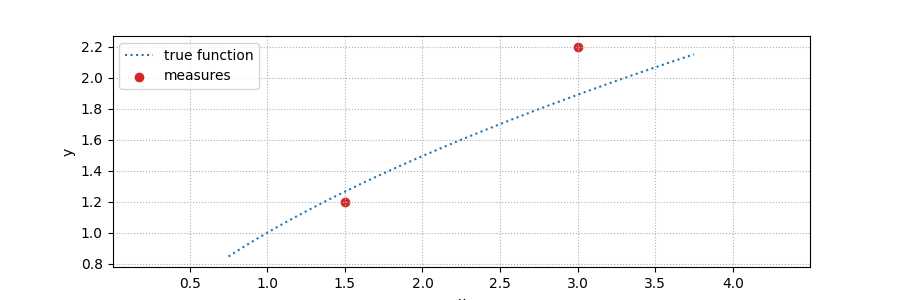

In [3]:
function_plot(xm, ym, f_true)

* We are underestimating the first point and overestimatng the second
* This may easily trick our simple model

## Learner Step

**We can now define the learner step**

For this simple case, we will use a basic curve fitting method:

In [5]:
from scipy.optimize import curve_fit

def learner_step(xm, ym):
    f = lambda x, a: x**a
    p = curve_fit(f, xm, ym)
    a_opt = p[0][0]
    return lambda x: x**a_opt

f_pred = learner_step(xm, ym)

## Learner Step

**We can plot the result of our first learning attempt**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
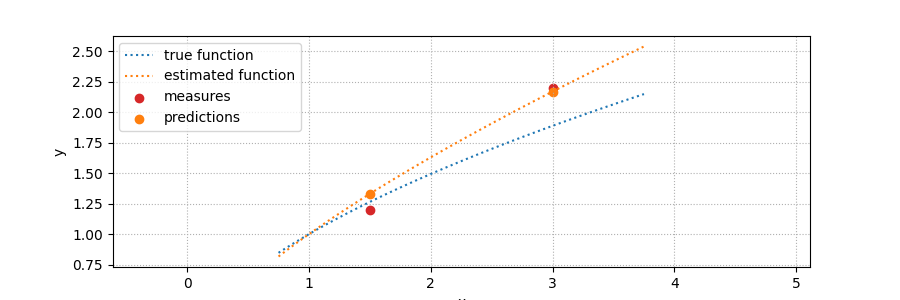

In [6]:
function_plot(xm, ym, f_true, f_pred)

* The learner model indeed overestimates the curve slope
* More data could fix the issue, but we will rely instead on _constraints_

## Taking Advantage of Constraints

**It's worth viewing our measurements and prediction in _output space_**

...Where they both look like _points_

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
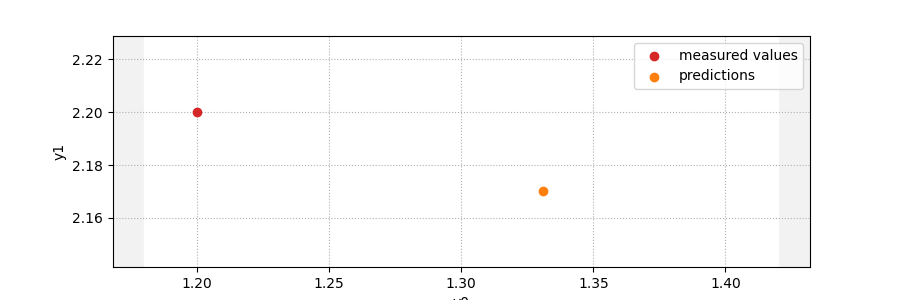

In [7]:
yp = f_pred(xm)
output_plot(xm, ym, yp)

## Visualizing Model Bias

**By changing the $\alpha$ in our model we can change the prediction vector**

...But only in way that are consistent with the model structure, i.e. $y = x^\alpha$

* We can draw a range of potential predictions in output space (part of the bias $B$)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
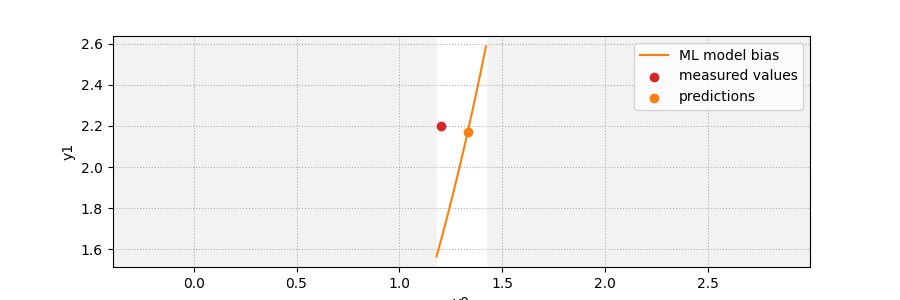

In [8]:
yp = f_pred(xm)
output_plot(xm, ym, yp, plot_bias=True)

* Our model is incapable of interpolating the measurements exactly

## Taking Advantage of Constraints

**Say we know that our two measurements must obey**
$$
y_1 \leq \frac{3}{2} y_0
$$

We can draw the feasible set $C$ in output space, too!

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
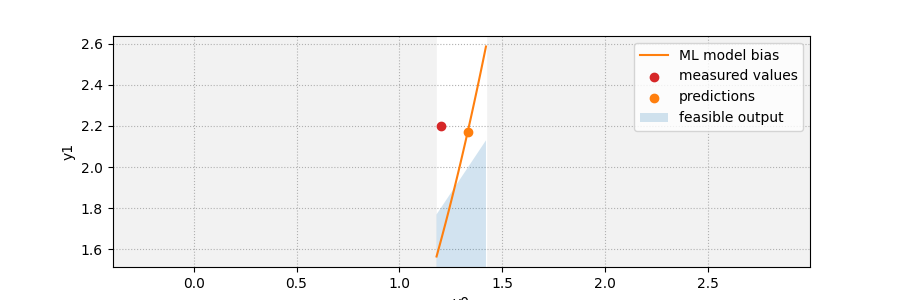

In [9]:
f_bound = lambda y0: 1.5*y0
output_plot(xm, ym, yp, plot_bias=True, f_bound=f_bound)

## Master Step

**We are now ready to define our master step (and perform the first)**

In [10]:
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize

def master_step_alpha(ym, yp, alpha=0.1):
    cst = LinearConstraint([[1.5, -1]], 0, np.inf)
    obj = lambda y: np.square(y - ym).sum() + 1/alpha * np.square(y - yp).sum()
    res = minimize(obj, yp, constraints=[cst])
    return res.x

yp = f_pred(xm)
yf = master_step_alpha(ym, yp)

* This is a constrained optimization problem
* For this simple case, we are using a basic solver for constrained QP

## Master Step

**We can visualize the result of the first master step**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
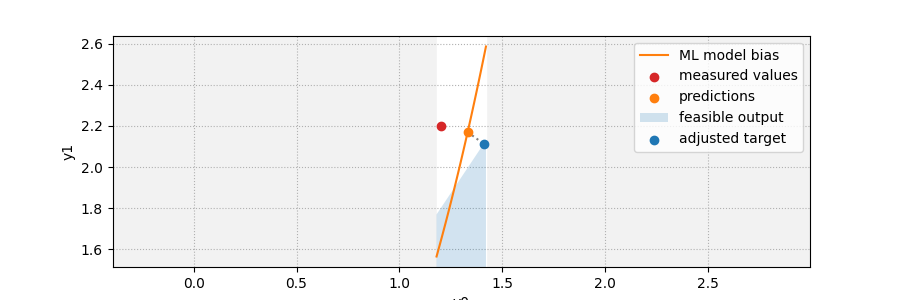

In [11]:
output_plot(xm, ym, yp, plot_bias=True, f_bound=f_bound, yf=yf)

* We chose a small $\alpha$ in our method, the result is (almost) a perfect projection
* Except that it is a bit closer to the true target

## Second Learner Step

**We can now perform and visualize a second learner step**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
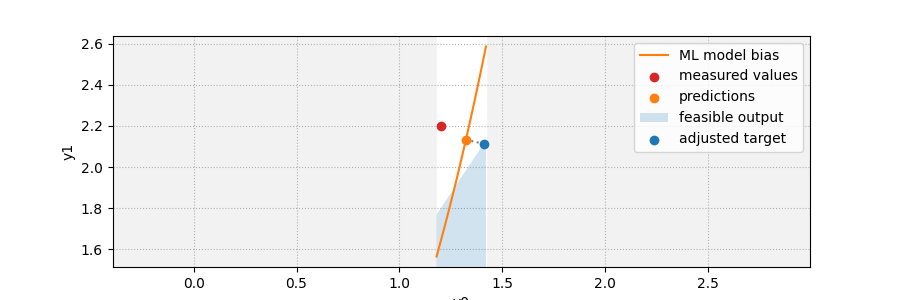

In [12]:
f_pred2 = learner_step(xm, yf)
yp2 = f_pred2(xm)
output_plot(xm, ym, yp2, plot_bias=True, f_bound=f_bound, yf=yf)

* This one is an actual projection on the model bias $B$

## The Full Method

**We are now ready to code the whole method**

In [13]:
# Repeat the process
def moving_target_alpha(n):
    ypl = []
    yfl = []

    f_pred = learner_step(xm, ym)
    yp = f_pred(xm)
    ypl.append(yp)
    for i in range(n):
        # Master step
        yf = master_step_alpha(ym, yp, alpha=0.001)
        yfl.append(yf)
        # Learner stpe
        f_pred = learner_step(xm, yf)
        yp = f_pred(xm)
        ypl.append(yp)
    return ypl, yfl, f_pred

* A serious implementation would be similar
* ...But based on SoA techniques for training and for handling the constraints

## The Full Method

**We can visualize a few iterations to see how MT works**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
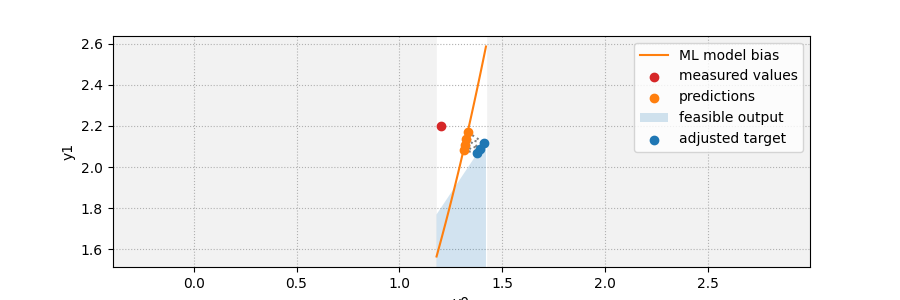

In [14]:
ypl, yfl, _ = moving_target_alpha(n=3)
output_plot(xm, ym, ypl, plot_bias=True, f_bound=f_bound, yf=yfl)

* Basically, MT zig-zags between the $B$ and the $C$ set
* This is not ideal, but it's the price we pay to enjoy a full decomposition

## The Final Outcome

**We can now inspect which kind of model we can obtain after some iterations**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
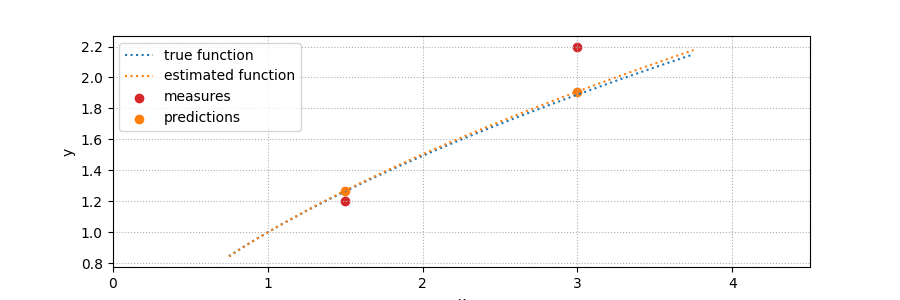

In [15]:
_, _, f_pred_final = moving_target_alpha(n=30)
function_plot(xm, ym, f_true, f_pred_final)

* This is very close to the true function!

# Some Results on Larger Datasets

## Evaluation Protocol

**Some details about the evaluation protocol**

* Two realistic tasks + one synthetic task
  - Regression with fairness constraints
  - Classification with fairness constraints
  - Classification with balance constraints
* Very tight thresholds on the constrained indicators
  - Primary metric = normalized violation, i.e. $\max(0, 1/\epsilon (g(x) - \epsilon)$
  - Secondary metric model accuracy
* Results on the training set
  - 5-fold cross validation to account
  - Good degree of generalization on the test set

## Evaluation Protocol

**The contenders**

* Semantic based regularization
* The [TFCO method](https://www.jmlr.org/papers/volume20/18-616/18-616.pdf) by Google research
* A "simplified Moving Targets", i.e.
  - First we project the true target on the feasible set
  - ...Then we train the ML model on the projected target
* Moving target (with a NN model)
* The best result that could be ever achieved on the training set
  - I.e. the projection of the true target on the feasible set
  - This kind of result can be obtained easily with high-variance models
  - ...At the cost of severe overfitting :-(

## Some Results on Larger Datasets

**Results for _regression_ with _fairness constraints_**

<center><img src="assets/fairness_regression.png" width="800px"/></center>

* Dataset size ~2,000
* In this case the constraint in convex and differentiable

## Some Results on Larger Datasets

**Results for _classification_ with _fairness constraints_**

<center><img src="assets/fairness_classification.png" width="800px"/></center>

* Dataset size ~32,0000
* In this case the constraint is non-differentiable

## Some Results on Larger Datasets

**Results for _classification_ with _balance constraints_**

<center><img src="assets/balance_classification.png" width="900px"/></center>

* Dataset size from ~150 to ~92,0000
* In this case the constraint is non-differentiable